### 04 - New experiments analysis, 20231112

In this notebook we analyze predictions metrics we have done so far:

training:
- both visual and position embeddings OFF (exp_005 and related).
- visual OFF, position ON (exp_004 and related).
- both visual and position embeddings ON (exp_003 and related). This is the baseline.

evaluation:
- both visual and position embeddings OFF (cames from exp_005 and related).
- visual OFF, position ON (cames from exp_004 and related).
- both visual and position embeddings ON (cames from exp_003 and related).
- visual OFF, position OFF, but using exp_003 and related.
- visual OFF, position ON, but using exp_003 and related.


*All metrics and results we're analyzing here belong to the validation set.

*When we say "exp_<xyz> and related" we refer to same experiment, but changing the seed. We trained five times each experiment, using five different seeds.

In [1]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from torchvision.ops import box_iou

from rec.utils import draw_bounding_boxes

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)

/home/nhormann/miniconda3/envs/rec-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BASE_PATH = "../code/rec/"

In [3]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst


def get_iou_column(df):
    df.loc[:, "bbox_raw"] = df.bbox_raw.apply(lambda v: np.resize(v, (1, 4)))
    df.loc[:, "bbox_pred"] = df.bbox_pred.apply(lambda v: np.resize(v, (1, 4)))
    df.loc[:, "iou"] = df.apply(lambda row: box_iou(torch.from_numpy(row["bbox_pred"]),
                                                    torch.from_numpy(row["bbox_raw"])), axis=1)
    df = df.astype({"iou": float})
    return df


def get_rec_counts(df_results, hits_col):
    counts = {
        hits_col: [],
        "counts": [],
        "rec_cls": []
    }
    for rec_cls in ["spatial", "ordinal", "relational", "intrinsic"]:
        counts["rec_cls"].append(rec_cls)
        mask_rec_cls = (df_results[rec_cls] == 1)
        counts[hits_col].append(df_results.loc[mask_rec_cls, hits_col].sum())
        counts["counts"].append(df_results.loc[mask_rec_cls, hits_col].shape[0])
    df = pd.DataFrame().from_dict(counts)
    df.loc[:, "exp_number"] = df_results.exp_number.unique()[0]
    df.loc[:, "use_visual_pos_emb"] = df_results.use_visual_pos_emb.unique()[0]
    df.loc[:, "use_visual_emb"] = df_results.use_visual_emb.unique()[0]
    df.loc[:, "exp_description"] = df_results.exp_description.unique()[0]
    df.loc[:, "hits_perc"] = round(df[hits_col] / df.counts * 100, 2)
    return df

### Read validation data from all available experiments results

Following dict's explanation:


exp_d:
```
key -> number of base experiment.

values -> list of lists[
    exp_number,
    validation_predictions_path(str),
    use_visual_pos_embeddings(boolean),
    use_visual_embeddings(boolean)
    ]
```

exp_descriptions:
```
key -> number of base experiment.
values -> description of the experiment.
```

In [4]:
exp_d = {
    "exp_003": [
        ["exp_003", "predictions_val.parquet", True, True],
        ["exp_003", "predictions_val_2023_11_06_01_48.parquet", False, False],
        ["exp_003", "predictions_val_2023_11_06_02_13.parquet", True, False],
        ["exp_023", "predictions_val.parquet", True, True],
        ["exp_024", "predictions_val.parquet", True, True],
        ["exp_025", "predictions_val.parquet", True, True],
        ["exp_026", "predictions_val.parquet", True, True],
    ],
    "exp_004": [
        ["exp_004", "predictions_val_2023_11_05_23_58.parquet", True, False],
        ["exp_033", "predictions_val_2023_11_12_00_59.parquet", True, False],
        ["exp_034", "predictions_val.parquet", True, False],
        ["exp_035", "predictions_val.parquet", True, False],
        ["exp_036", "predictions_val.parquet", True, False],
    ],
    "exp_005": [
        ["exp_005", "predictions_val_2023_11_05_23_58.parquet", False, False],
        ["exp_028", "predictions_val_2023_11_05_23_58.parquet", False, False],
        ["exp_029", "predictions_val_2023_11_06_01_05.parquet", False, False],
        ["exp_030", "predictions_val_2023_11_06_01_05.parquet", False, False],
        ["exp_031", "predictions_val_2023_11_06_01_08.parquet", False, False],
    ],
    "exp_037": [
        ["exp_037", "predictions_val_2023_11_21_04_55.parquet", False, True],
        ["exp_038", "predictions_val_2023_11_20_15_21.parquet", False, True],
        ["exp_039", "predictions_val_2023_11_20_15_21.parquet", False, True],
        ["exp_040", "predictions_val_2023_11_20_16_11.parquet", False, True],
        ["exp_041", "predictions_val_2023_11_20_16_33.parquet", False, True],
    ]
}
exp_descriptions = {
    "exp_003": "Exp from the section 3.1 of the paper.",
    "exp_004": "Exp from the section 3.1 of the paper, visual position embedding ON, visual embedding OFF.",
    "exp_005": "Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding OFF.",
    "exp_037": "Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding ON.",
}

In [5]:
df_preds_list = []
df_metrics_lst_25 = []
df_metrics_lst_50 = []
for exp_base, lst_exps in exp_d.items():
    exp_base_description = exp_descriptions[exp_base]
    for exp_number, exp_filename, use_visual_pos_emb, use_visual_emb in lst_exps:
        df = pd.read_parquet(f"../models/{exp_number}/{exp_filename}")
        df.loc[:, "exp_number"] = exp_number
        df.loc[:, "use_visual_pos_emb"] = use_visual_pos_emb
        df.loc[:, "use_visual_emb"] = use_visual_emb
        df.loc[:, "exp_description"] = exp_base_description
        df = get_iou_column(df)
        df = df.rename(columns={"hits": "hits_50"})
        df.loc[:, "hits_25"] = (df.iou > 0.25).astype(int)
        df_m_25 = get_rec_counts(df, "hits_25")
        df_m_50 = get_rec_counts(df, "hits_50")
        df_preds_list.append(df)
        df_metrics_lst_25.append(df_m_25)
        df_metrics_lst_50.append(df_m_50)
df_preds_val = pd.concat(df_preds_list, ignore_index=True)
df_metrics_val_25 = pd.concat(df_metrics_lst_25, ignore_index=True)
df_metrics_val_50 = pd.concat(df_metrics_lst_50, ignore_index=True)

### Threshold = 0.25

In [6]:
df = df_metrics_val_25.query("use_visual_pos_emb == True and use_visual_emb == True")

In [7]:
df

,hits_25,counts,rec_cls,exp_number,use_visual_pos_emb,use_visual_emb,exp_description,hits_perc
0,3241,4028,spatial,exp_003,True,True,Exp from the section 3.1 of the paper.,80.46
1,50,90,ordinal,exp_003,True,True,Exp from the section 3.1 of the paper.,55.56
2,831,1205,relational,exp_003,True,True,Exp from the section 3.1 of the paper.,68.96
3,2081,2290,intrinsic,exp_003,True,True,Exp from the section 3.1 of the paper.,90.87
12,3235,4028,spatial,exp_023,True,True,Exp from the section 3.1 of the paper.,80.31
13,45,90,ordinal,exp_023,True,True,Exp from the section 3.1 of the paper.,50.00
14,831,1205,relational,exp_023,True,True,Exp from the section 3.1 of the paper.,68.96
15,2084,2290,intrinsic,exp_023,True,True,Exp from the section 3.1 of the paper.,91.00
16,3206,4028,spatial,exp_024,True,True,Exp from the section 3.1 of the paper.,79.59
17,52,90,ordinal,exp_024,True,True,Exp from the section 3.1 of the paper.,57.78


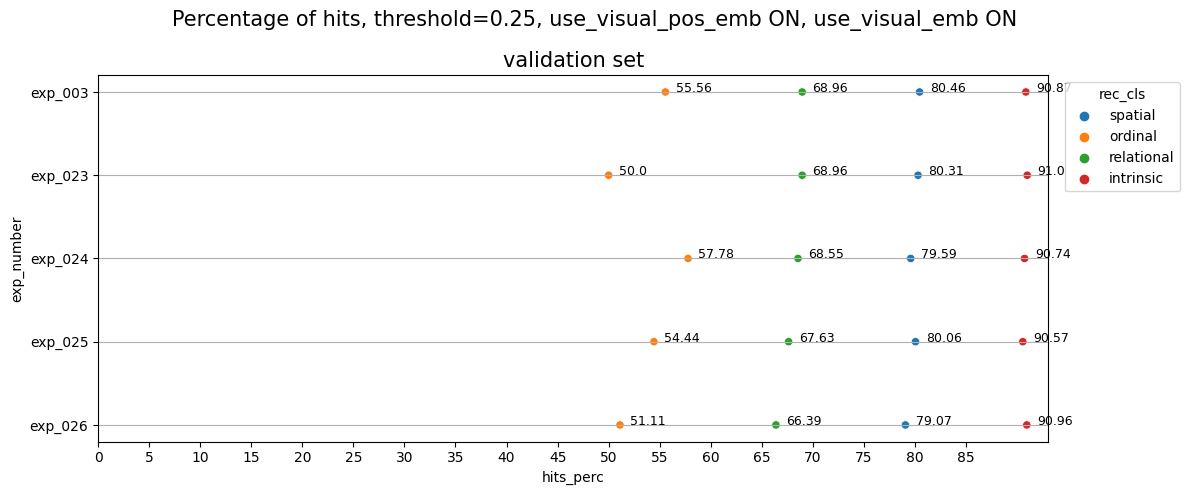

In [8]:
fig, ax = plt.subplots(figsize=(12, 5))
fig.suptitle('Percentage of hits, threshold=0.25, use_visual_pos_emb ON, use_visual_emb ON', fontsize=15)
plt.rcParams['axes.grid'] = True
ax.set_title("validation set", size=15)
ax = sns.scatterplot(data=df, x="hits_perc", y="exp_number", hue="rec_cls", ax=ax)
for _, row in df.loc[:, ["hits_perc", "exp_number"]].iterrows():
    ax.text(x=row["hits_perc"] + 1, y=row["exp_number"], s=row["hits_perc"], fontsize=9)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.01, 1))
plt.xticks([i for i in range(0, 90, 5)])
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [9]:
df = df_metrics_val_25.query("use_visual_pos_emb == True and use_visual_emb == False")

In [10]:
df

,hits_25,counts,rec_cls,exp_number,use_visual_pos_emb,use_visual_emb,exp_description,hits_perc
8,304,4028,spatial,exp_003,True,False,Exp from the section 3.1 of the paper.,7.55
9,2,90,ordinal,exp_003,True,False,Exp from the section 3.1 of the paper.,2.22
10,66,1205,relational,exp_003,True,False,Exp from the section 3.1 of the paper.,5.48
11,312,2290,intrinsic,exp_003,True,False,Exp from the section 3.1 of the paper.,13.62
28,2286,4028,spatial,exp_004,True,False,"Exp from the section 3.1 of the paper, visual position embedding ON, visual embedding OFF.",56.75
29,24,90,ordinal,exp_004,True,False,"Exp from the section 3.1 of the paper, visual position embedding ON, visual embedding OFF.",26.67
30,493,1205,relational,exp_004,True,False,"Exp from the section 3.1 of the paper, visual position embedding ON, visual embedding OFF.",40.91
31,1632,2290,intrinsic,exp_004,True,False,"Exp from the section 3.1 of the paper, visual position embedding ON, visual embedding OFF.",71.27
32,2277,4028,spatial,exp_033,True,False,"Exp from the section 3.1 of the paper, visual position embedding ON, visual embedding OFF.",56.53
33,29,90,ordinal,exp_033,True,False,"Exp from the section 3.1 of the paper, visual position embedding ON, visual embedding OFF.",32.22


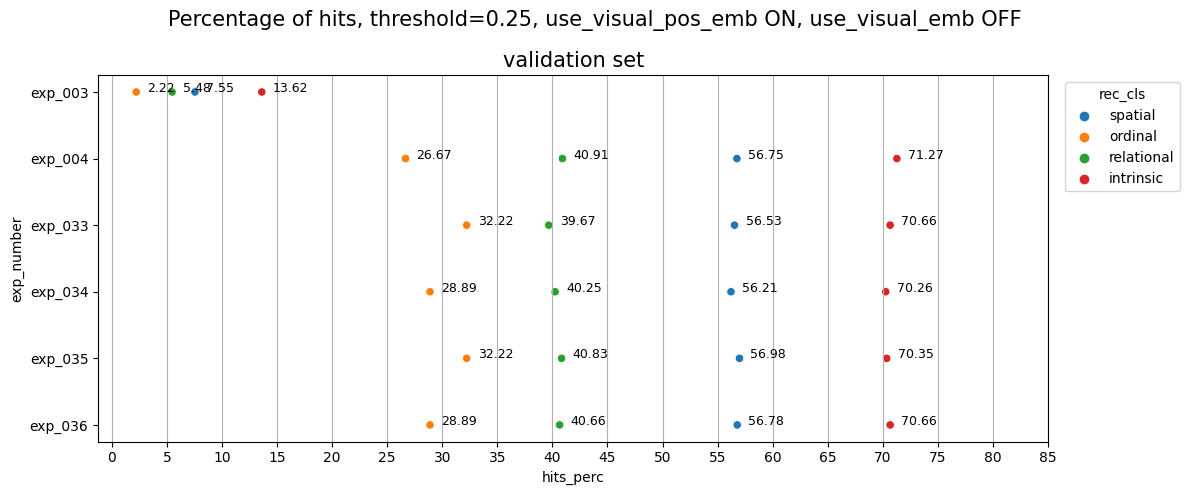

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))
fig.suptitle('Percentage of hits, threshold=0.25, use_visual_pos_emb ON, use_visual_emb OFF', fontsize=15)
plt.rcParams['axes.grid'] = True
ax.set_title("validation set", size=15)
ax = sns.scatterplot(data=df, x="hits_perc", y="exp_number", hue="rec_cls", ax=ax)
for _, row in df.loc[:, ["hits_perc", "exp_number"]].iterrows():
    ax.text(x=row["hits_perc"] + 1, y=row["exp_number"], s=row["hits_perc"], fontsize=9)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.01, 1))
plt.xticks([i for i in range(0, 90, 5)])
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [12]:
df = df_metrics_val_25.query("use_visual_pos_emb == False and use_visual_emb == False")

In [13]:
df

,hits_25,counts,rec_cls,exp_number,use_visual_pos_emb,use_visual_emb,exp_description,hits_perc
4,368,4028,spatial,exp_003,False,False,Exp from the section 3.1 of the paper.,9.14
5,7,90,ordinal,exp_003,False,False,Exp from the section 3.1 of the paper.,7.78
6,92,1205,relational,exp_003,False,False,Exp from the section 3.1 of the paper.,7.63
7,422,2290,intrinsic,exp_003,False,False,Exp from the section 3.1 of the paper.,18.43
48,2241,4028,spatial,exp_005,False,False,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding OFF.",55.64
49,27,90,ordinal,exp_005,False,False,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding OFF.",30.00
50,471,1205,relational,exp_005,False,False,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding OFF.",39.09
51,1613,2290,intrinsic,exp_005,False,False,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding OFF.",70.44
52,2226,4028,spatial,exp_028,False,False,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding OFF.",55.26
53,25,90,ordinal,exp_028,False,False,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding OFF.",27.78


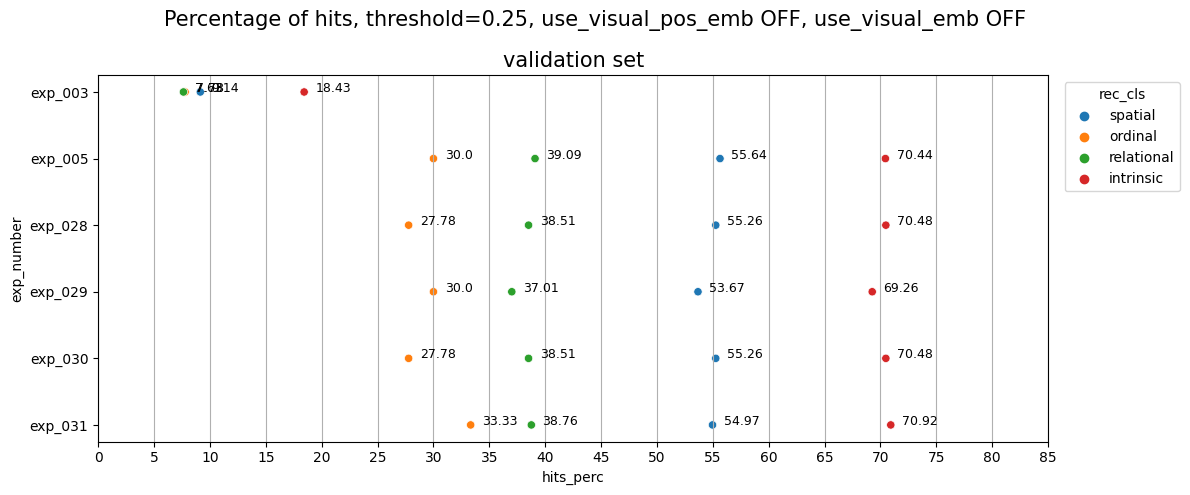

In [14]:
fig, ax = plt.subplots(figsize=(12, 5))
fig.suptitle('Percentage of hits, threshold=0.25, use_visual_pos_emb OFF, use_visual_emb OFF', fontsize=15)
plt.rcParams['axes.grid'] = True
ax.set_title("validation set", size=15)
ax = sns.scatterplot(data=df, x="hits_perc", y="exp_number", hue="rec_cls", ax=ax)
for _, row in df.loc[:, ["hits_perc", "exp_number"]].iterrows():
    ax.text(x=row["hits_perc"] + 1, y=row["exp_number"], s=row["hits_perc"], fontsize=9)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.01, 1))
plt.xticks([i for i in range(0, 90, 5)])
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [15]:
df = df_metrics_val_25.query("use_visual_pos_emb == False and use_visual_emb == True")

In [16]:
df

,hits_25,counts,rec_cls,exp_number,use_visual_pos_emb,use_visual_emb,exp_description,hits_perc
68,3060,4028,spatial,exp_037,False,True,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding ON.",75.97
69,48,90,ordinal,exp_037,False,True,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding ON.",53.33
70,751,1205,relational,exp_037,False,True,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding ON.",62.32
71,2027,2290,intrinsic,exp_037,False,True,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding ON.",88.52
72,3003,4028,spatial,exp_038,False,True,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding ON.",74.55
73,42,90,ordinal,exp_038,False,True,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding ON.",46.67
74,713,1205,relational,exp_038,False,True,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding ON.",59.17
75,2018,2290,intrinsic,exp_038,False,True,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding ON.",88.12
76,3014,4028,spatial,exp_039,False,True,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding ON.",74.83
77,42,90,ordinal,exp_039,False,True,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding ON.",46.67


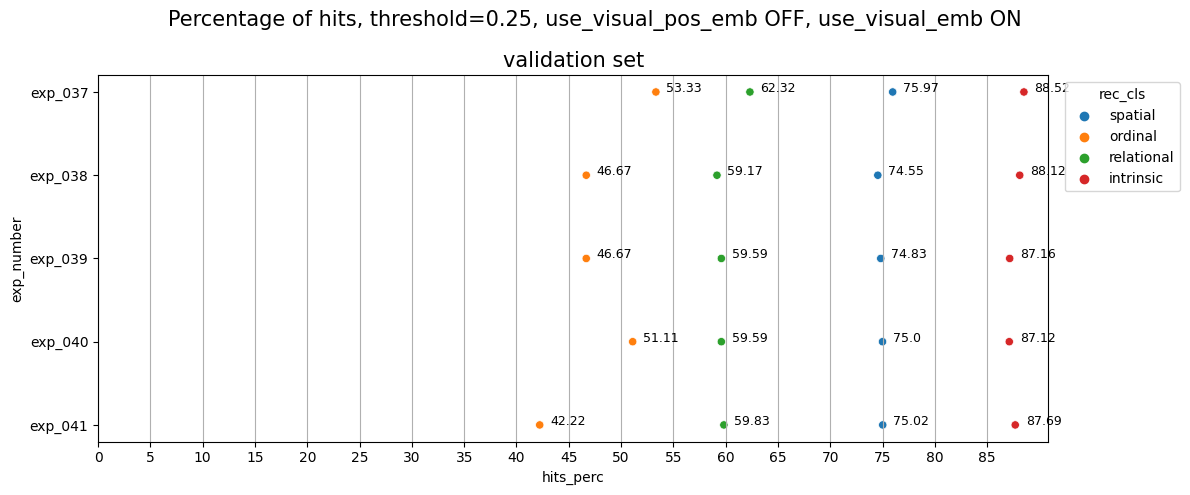

In [17]:
fig, ax = plt.subplots(figsize=(12, 5))
fig.suptitle('Percentage of hits, threshold=0.25, use_visual_pos_emb OFF, use_visual_emb ON', fontsize=15)
plt.rcParams['axes.grid'] = True
ax.set_title("validation set", size=15)
ax = sns.scatterplot(data=df, x="hits_perc", y="exp_number", hue="rec_cls", ax=ax)
for _, row in df.loc[:, ["hits_perc", "exp_number"]].iterrows():
    ax.text(x=row["hits_perc"] + 1, y=row["exp_number"], s=row["hits_perc"], fontsize=9)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.01, 1))
plt.xticks([i for i in range(0, 90, 5)])
plt.grid(axis="y")
plt.tight_layout()
plt.show()

### Threshold = 0.50

In [18]:
df = df_metrics_val_50.query("use_visual_pos_emb == True and use_visual_emb == True")

In [19]:
df

,hits_50,counts,rec_cls,exp_number,use_visual_pos_emb,use_visual_emb,exp_description,hits_perc
0,2584.0,4028,spatial,exp_003,True,True,Exp from the section 3.1 of the paper.,64.15
1,39.0,90,ordinal,exp_003,True,True,Exp from the section 3.1 of the paper.,43.33
2,586.0,1205,relational,exp_003,True,True,Exp from the section 3.1 of the paper.,48.63
3,1908.0,2290,intrinsic,exp_003,True,True,Exp from the section 3.1 of the paper.,83.32
12,2567.0,4028,spatial,exp_023,True,True,Exp from the section 3.1 of the paper.,63.73
13,36.0,90,ordinal,exp_023,True,True,Exp from the section 3.1 of the paper.,40.00
14,600.0,1205,relational,exp_023,True,True,Exp from the section 3.1 of the paper.,49.79
15,1922.0,2290,intrinsic,exp_023,True,True,Exp from the section 3.1 of the paper.,83.93
16,2542.0,4028,spatial,exp_024,True,True,Exp from the section 3.1 of the paper.,63.11
17,36.0,90,ordinal,exp_024,True,True,Exp from the section 3.1 of the paper.,40.00


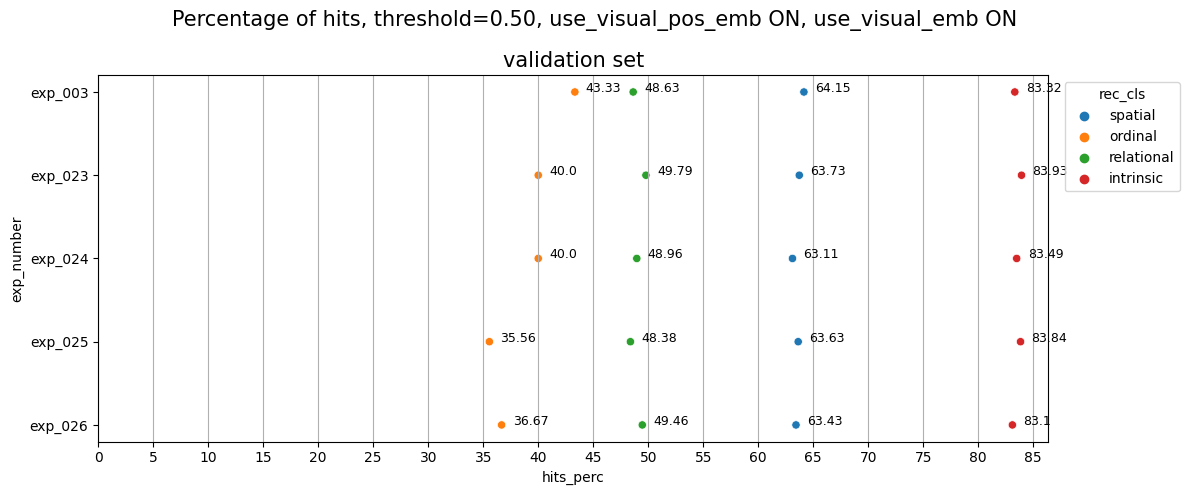

In [20]:
fig, ax = plt.subplots(figsize=(12, 5))
fig.suptitle('Percentage of hits, threshold=0.50, use_visual_pos_emb ON, use_visual_emb ON', fontsize=15)
plt.rcParams['axes.grid'] = True
ax.set_title("validation set", size=15)
ax = sns.scatterplot(data=df, x="hits_perc", y="exp_number", hue="rec_cls", ax=ax)
for _, row in df.loc[:, ["hits_perc", "exp_number"]].iterrows():
    ax.text(x=row["hits_perc"] + 1, y=row["exp_number"], s=row["hits_perc"], fontsize=9)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.01, 1))
plt.xticks([i for i in range(0, 90, 5)])
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [21]:
df = df_metrics_val_50.query("use_visual_pos_emb == True and use_visual_emb == False")

In [22]:
df

,hits_50,counts,rec_cls,exp_number,use_visual_pos_emb,use_visual_emb,exp_description,hits_perc
8,67.0,4028,spatial,exp_003,True,False,Exp from the section 3.1 of the paper.,1.66
9,0.0,90,ordinal,exp_003,True,False,Exp from the section 3.1 of the paper.,0.00
10,17.0,1205,relational,exp_003,True,False,Exp from the section 3.1 of the paper.,1.41
11,96.0,2290,intrinsic,exp_003,True,False,Exp from the section 3.1 of the paper.,4.19
28,1016.0,4028,spatial,exp_004,True,False,"Exp from the section 3.1 of the paper, visual position embedding ON, visual embedding OFF.",25.22
29,8.0,90,ordinal,exp_004,True,False,"Exp from the section 3.1 of the paper, visual position embedding ON, visual embedding OFF.",8.89
30,190.0,1205,relational,exp_004,True,False,"Exp from the section 3.1 of the paper, visual position embedding ON, visual embedding OFF.",15.77
31,1081.0,2290,intrinsic,exp_004,True,False,"Exp from the section 3.1 of the paper, visual position embedding ON, visual embedding OFF.",47.21
32,1017.0,4028,spatial,exp_033,True,False,"Exp from the section 3.1 of the paper, visual position embedding ON, visual embedding OFF.",25.25
33,8.0,90,ordinal,exp_033,True,False,"Exp from the section 3.1 of the paper, visual position embedding ON, visual embedding OFF.",8.89


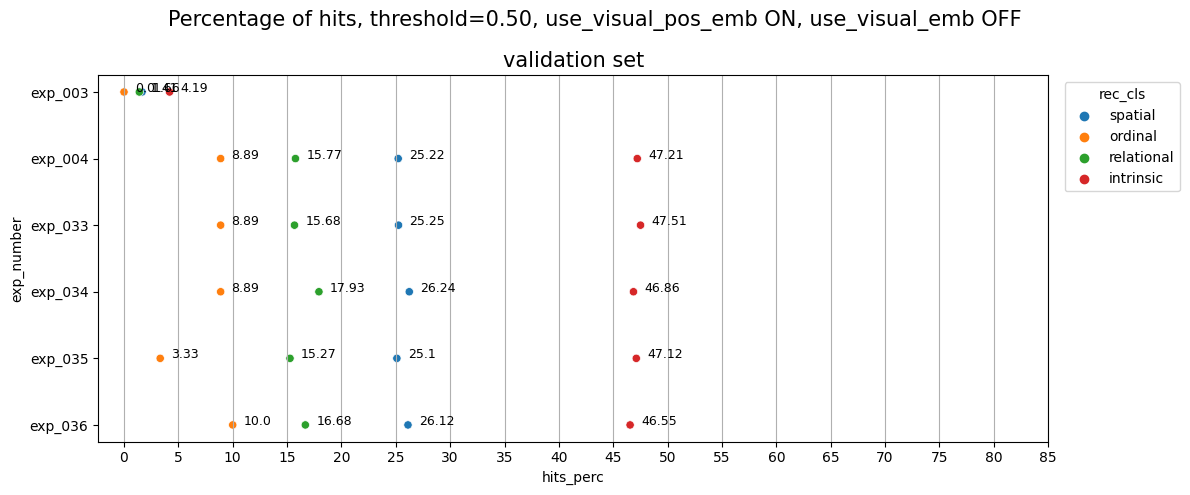

In [23]:
fig, ax = plt.subplots(figsize=(12, 5))
fig.suptitle('Percentage of hits, threshold=0.50, use_visual_pos_emb ON, use_visual_emb OFF', fontsize=15)
plt.rcParams['axes.grid'] = True
ax.set_title("validation set", size=15)
ax = sns.scatterplot(data=df, x="hits_perc", y="exp_number", hue="rec_cls", ax=ax)
for _, row in df.loc[:, ["hits_perc", "exp_number"]].iterrows():
    ax.text(x=row["hits_perc"] + 1, y=row["exp_number"], s=row["hits_perc"], fontsize=9)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.01, 1))
plt.xticks([i for i in range(0, 90, 5)])
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [24]:
df = df_metrics_val_50.query("use_visual_pos_emb == False and use_visual_emb == False")

In [25]:
df

,hits_50,counts,rec_cls,exp_number,use_visual_pos_emb,use_visual_emb,exp_description,hits_perc
4,90.0,4028,spatial,exp_003,False,False,Exp from the section 3.1 of the paper.,2.23
5,1.0,90,ordinal,exp_003,False,False,Exp from the section 3.1 of the paper.,1.11
6,23.0,1205,relational,exp_003,False,False,Exp from the section 3.1 of the paper.,1.91
7,173.0,2290,intrinsic,exp_003,False,False,Exp from the section 3.1 of the paper.,7.55
48,1005.0,4028,spatial,exp_005,False,False,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding OFF.",24.95
49,5.0,90,ordinal,exp_005,False,False,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding OFF.",5.56
50,201.0,1205,relational,exp_005,False,False,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding OFF.",16.68
51,1051.0,2290,intrinsic,exp_005,False,False,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding OFF.",45.90
52,981.0,4028,spatial,exp_028,False,False,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding OFF.",24.35
53,8.0,90,ordinal,exp_028,False,False,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding OFF.",8.89


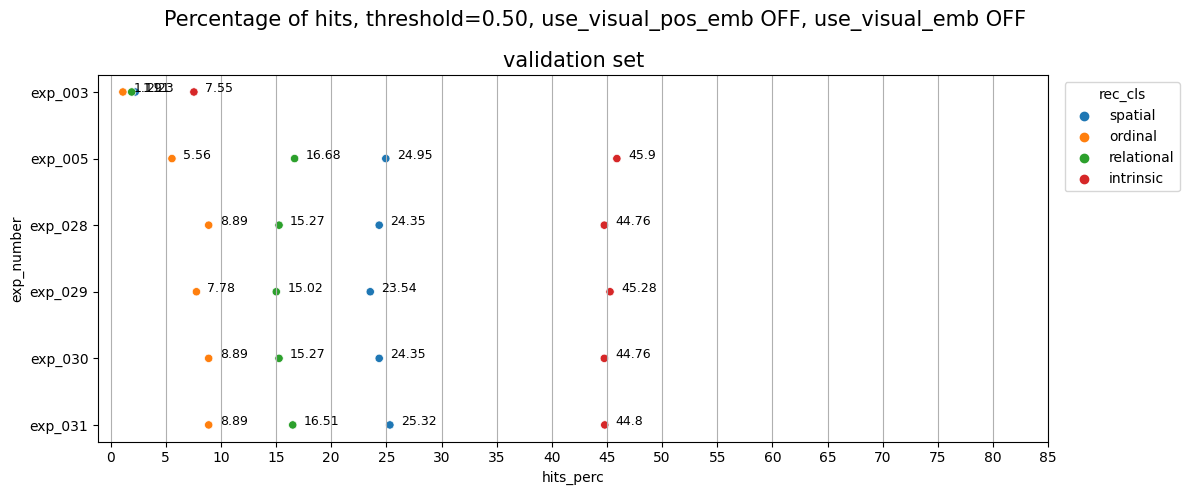

In [26]:
fig, ax = plt.subplots(figsize=(12, 5))
fig.suptitle('Percentage of hits, threshold=0.50, use_visual_pos_emb OFF, use_visual_emb OFF', fontsize=15)
plt.rcParams['axes.grid'] = True
ax.set_title("validation set", size=15)
ax = sns.scatterplot(data=df, x="hits_perc", y="exp_number", hue="rec_cls", ax=ax)
for _, row in df.loc[:, ["hits_perc", "exp_number"]].iterrows():
    ax.text(x=row["hits_perc"] + 1, y=row["exp_number"], s=row["hits_perc"], fontsize=9)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.01, 1))
plt.xticks([i for i in range(0, 90, 5)])
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [27]:
df = df_metrics_val_50.query("use_visual_pos_emb == False and use_visual_emb == True")

In [28]:
df

,hits_50,counts,rec_cls,exp_number,use_visual_pos_emb,use_visual_emb,exp_description,hits_perc
68,2259.0,4028,spatial,exp_037,False,True,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding ON.",56.08
69,33.0,90,ordinal,exp_037,False,True,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding ON.",36.67
70,480.0,1205,relational,exp_037,False,True,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding ON.",39.83
71,1817.0,2290,intrinsic,exp_037,False,True,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding ON.",79.34
72,2234.0,4028,spatial,exp_038,False,True,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding ON.",55.46
73,28.0,90,ordinal,exp_038,False,True,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding ON.",31.11
74,468.0,1205,relational,exp_038,False,True,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding ON.",38.84
75,1784.0,2290,intrinsic,exp_038,False,True,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding ON.",77.90
76,2179.0,4028,spatial,exp_039,False,True,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding ON.",54.10
77,23.0,90,ordinal,exp_039,False,True,"Exp from the section 3.1 of the paper, visual position embedding OFF, visual embedding ON.",25.56


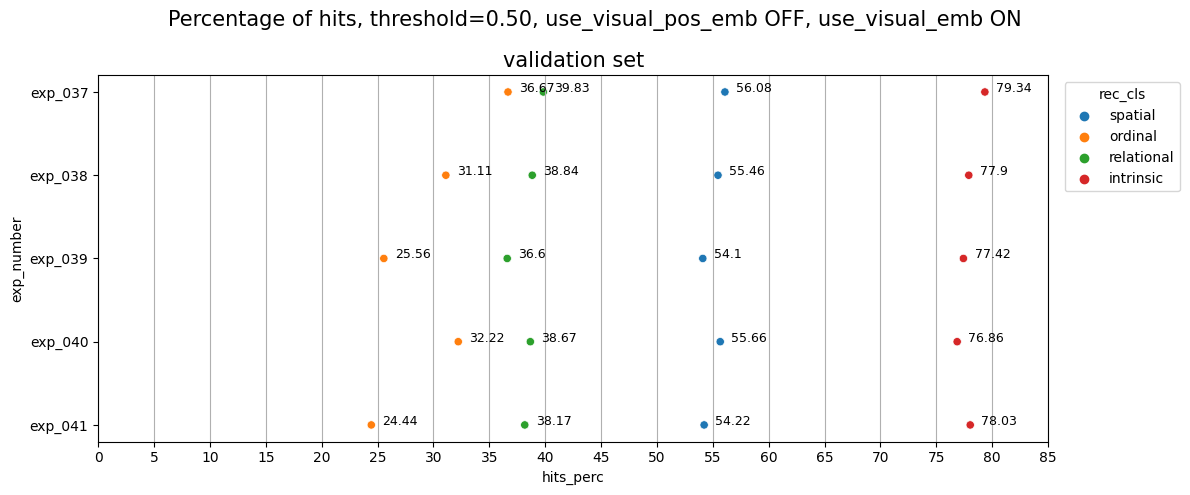

In [29]:
fig, ax = plt.subplots(figsize=(12, 5))
fig.suptitle('Percentage of hits, threshold=0.50, use_visual_pos_emb OFF, use_visual_emb ON', fontsize=15)
plt.rcParams['axes.grid'] = True
ax.set_title("validation set", size=15)
ax = sns.scatterplot(data=df, x="hits_perc", y="exp_number", hue="rec_cls", ax=ax)
for _, row in df.loc[:, ["hits_perc", "exp_number"]].iterrows():
    ax.text(x=row["hits_perc"] + 1, y=row["exp_number"], s=row["hits_perc"], fontsize=9)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.01, 1))
plt.xticks([i for i in range(0, 90, 5)])
plt.grid(axis="y")
plt.tight_layout()
plt.show()